We'll be doing a classic survival analysis model, using Cox PH to look at sex differences in time to death (aka. longevity) using data from the U.S. National Health Interview Survey. https://ihis.ipums.org/
This data is particularly great because they have both year of birth and year of death. **Death records stop in 2009 (when the dataset was considered complete), so any people who are still living in 2009 will need to be right-censored**.

**Some people do not have date of birth. Those cases will be truncated**.

Let's start by loading the data, https://tf-assets-prod.s3.amazonaws.com/tf-curric/data-science/nhis.csv
taking a look at it, and cleaning it up:


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_csv(r'C:\Users\katec\Thinkful\data_collections\nhis.csv')

data.shape


(1605246, 10)

In [3]:
data.head()

,Unnamed: 0,YEAR,NHISPID,AGE,SEX,SEXORIEN,MARSTAT,BIRTHYR,MORTSTAT,MORTDODY
0,2744230,1986,1986109602890101,60,1,NaN,11,NaN,1.0,2005.0
1,2744231,1986,1986109602890102,54,2,NaN,11,NaN,1.0,2010.0
2,2744232,1986,1986109602890103,21,1,NaN,50,NaN,2.0,9999.0
3,2744233,1986,1986109602890201,46,1,NaN,11,NaN,2.0,9999.0
4,2744234,1986,1986109602890202,38,2,NaN,11,NaN,2.0,9999.0


C:\Users\katec\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\Users\katec\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\katec\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.h

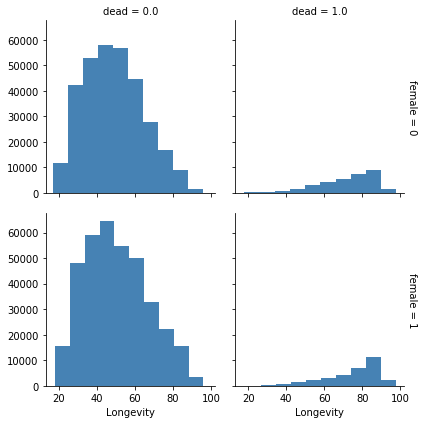

In [4]:
# Dropping cases where birth year is not known
data2 =data[(data['BIRTHYR']<=2009) & (data['BIRTHYR'].notnull())]

# Calculating time-to-event
data2['Longevity']= data2['MORTDODY'] - data2['BIRTHYR']

# Creating a 'status' variable where 1 means dead and 0 means alive as of 2009
data2['dead']=2-data2['MORTSTAT']

# For people who were alive as of 2009, calculating their longevity as their age in 2009
data2.loc[data2['dead']==0,'Longevity'] = 2009 -data2.loc[data2['dead']==0,'BIRTHYR'] 

# Creating a binary variable where 1 = female and 0 = male
data2['female'] = (data2['SEX'] == 2).astype(int)



g = sns.FacetGrid(data2, row='female', col='dead',margin_titles=True)
g.map(plt.hist, 'Longevity', color='steelblue', lw=0)
plt.show()

In [5]:
data2.head()

,Unnamed: 0,YEAR,NHISPID,AGE,SEX,SEXORIEN,MARSTAT,BIRTHYR,MORTSTAT,MORTDODY,Longevity,dead,female
829402,3928174,1997,19970003080101,33,2,NaN,11,1963.0,2.0,9999.0,46.0,0.0,1
829403,3928175,1997,19970003080102,36,1,NaN,11,1960.0,2.0,9999.0,49.0,0.0,0
829404,3928178,1997,19970003090101,42,1,NaN,11,1954.0,1.0,1999.0,45.0,1.0,0
829405,3928179,1997,19970003090102,52,2,NaN,11,1944.0,2.0,9999.0,65.0,0.0,1
829407,3928182,1997,19970003100101,41,1,NaN,11,1955.0,2.0,9999.0,54.0,0.0,0


In [6]:
data2.shape

(754219, 13)

In [7]:
#calculate the Hazard risk for each age
import statsmodels.api as sm
import statsmodels.formula.api as smf

#sf = sm.SurvfuncRight(df[time], df['status])
sf = sm.SurvfuncRight(data2['Longevity'], data2['dead'])
sf.summary().head()

,Surv prob,Surv prob SE,num at risk,num events
Time,,,,
18.0,0.999997,0.000002,754217,2.0
19.0,0.999981,0.000005,753439,12.0
20.0,0.999940,0.000009,751911,31.0
21.0,0.999879,0.000013,749414,46.0
22.0,0.999825,0.000015,746169,40.0


(0.85, 1)

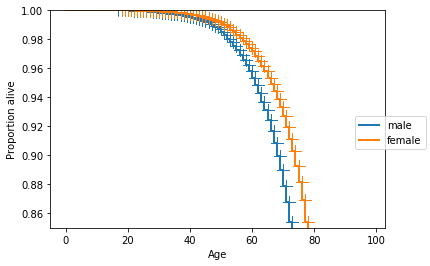

In [8]:
# survival plot for the men and the women
# Code for this plot modified from the statsmodels documentation at http://www.statsmodels.org/dev/duration.html

groups = data2.groupby('female')
ax = plt.axes()
sexes = ['male','female']
# Fitting a survival function for each group
for group in groups:
    sf = sm.SurvfuncRight(group[1]['Longevity'], group[1]['dead'])
    sf.plot(ax)
li = ax.get_lines()
plt.figlegend((li[0], li[2]), sexes, 'center right')
ax.set_ylabel('Proportion alive')
ax.set_xlabel('Age')
ax.set_autoscaley_on(False)
ax.set_ylim([.85,1])


In [9]:
#cox_ph
mod = smf.phreg('Longevity ~  female', # The model
                data2, # The data
                status=data2['dead'].values # Whether values are right-censored
                ) 
rslt = mod.fit()
rslt.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                       Results: PHReg
=============================================================
Model:                  PH Reg        Sample size:     754217
Dependent variable:     Longevity     Num. events:     67383 
Ties:                   Breslow                              
-------------------------------------------------------------
        log HR log HR SE   HR      t     P>|t|  [0.025 0.975]
-------------------------------------------------------------
female -0.4460    0.0078 0.6402 -57.5296 0.0000 0.6306 0.6500
=============================================================
Confidence intervals are for the hazard ratios
"""

It looks like the difference is meaningful. The **convention is to report and interpret the Hazard Ratio (HR) rather than the log HR**. According to the Cox PH, at any given age, women are **64% less likely to die than men, with a 95% confidence interval of 63% to 65%**. This difference is statistically significant at 𝛼 of .05 (p < .0001). Our **confidence interval is tiny because our sample is so big**!

**Looking from the plot to the model, you may notice that the data tell a slightly different story**. The survival rate **discrepancy seems to shrink a bit after age 80**. This **suggests that either we should include some additional features in the model to try and account for this discrepancy, or we should use a different modeling technique that doesn't assume that the effects of features are consistent across all values**.

We can plot the predicted survival rates from the model:

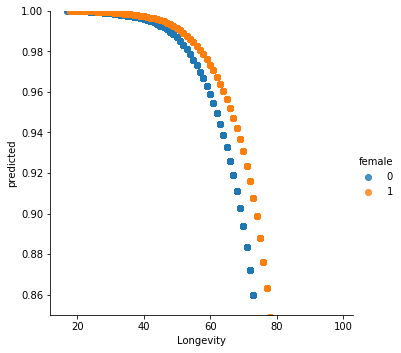

In [10]:
#plot survival rates from the model
data3=data2[(data2['Longevity'].notnull()) & (data2['female'].notnull()) & (data2['dead'].notnull())]
data3['predicted'] = rslt.predict(pred_type='surv').predicted_values



sns.lmplot(x='Longevity', y='predicted', hue='female', data=data3,fit_reg=False,lowess=True)
plt.ylim(.85, 1)
plt.show()

In [11]:
data3.head()

,Unnamed: 0,YEAR,NHISPID,AGE,SEX,SEXORIEN,MARSTAT,BIRTHYR,MORTSTAT,MORTDODY,Longevity,dead,female,predicted
829402,3928174,1997,19970003080101,33,2,NaN,11,1963.0,2.0,9999.0,46.0,0.0,1,0.994803
829403,3928175,1997,19970003080102,36,1,NaN,11,1960.0,2.0,9999.0,49.0,0.0,0,0.988401
829404,3928178,1997,19970003090101,42,1,NaN,11,1954.0,1.0,1999.0,45.0,1.0,0,0.992777
829405,3928179,1997,19970003090102,52,2,NaN,11,1944.0,2.0,9999.0,65.0,0.0,1,0.956459
829407,3928182,1997,19970003100101,41,1,NaN,11,1955.0,2.0,9999.0,54.0,0.0,0,0.978739


In [13]:
data3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 754219 entries, 829402 to 1605245
Data columns (total 14 columns):
Unnamed: 0    754219 non-null int64
YEAR          754219 non-null int64
NHISPID       754219 non-null int64
AGE           754219 non-null int64
SEX           754219 non-null int64
SEXORIEN      0 non-null float64
MARSTAT       754219 non-null int64
BIRTHYR       754219 non-null float64
MORTSTAT      754219 non-null float64
MORTDODY      754219 non-null float64
Longevity     754219 non-null float64
dead          754219 non-null float64
female        754219 non-null int32
predicted     754219 non-null float64
dtypes: float64(7), int32(1), int64(6)
memory usage: 83.4 MB


Going back to the survival rates from the raw data, it does appear this model is missing some elements, including the shrinkage in the gender difference after 80, but also the leveling-off of the survival rate once people get to 90 years or older. Again, adding more parameters may help.


## Drill

They say that people who get married live longer than people who don't. Test that assertion by using marital status as an additional feature in your model. You'll need to create a feature that differentiates the never married from everyone else- check the codebook https://nhis.ipums.org/nhis-action/variables/MARSTAT#codes_section
to get started. Does marriage make a difference? Calculate the survival plot and the hazard ratio for being married at any point a lifetime.


never married = 50;  
unknown marital status = 99;  
all other = 10(married), 11 (married, sp present), 12 (married, sp not present), 13 (mararied, sp presence unknwn), 20 (widowed), 30 (divorced), 40 (separated)


In [21]:
# continue to use data3 with modifications
# drop records with unknown marital status
data4 =data2[(data2['MARSTAT']!=99) & (data2['MARSTAT'].notnull())]

# Creating a binary variable where 1 = married and 0 = never married
data4['married'] = (data4['MARSTAT'] != 50).astype(int)
data4.head()


C:\Users\katec\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,Unnamed: 0,YEAR,NHISPID,AGE,SEX,SEXORIEN,MARSTAT,BIRTHYR,MORTSTAT,MORTDODY,Longevity,dead,female,married
829402,3928174,1997,19970003080101,33,2,NaN,11,1963.0,2.0,9999.0,46.0,0.0,1,1
829403,3928175,1997,19970003080102,36,1,NaN,11,1960.0,2.0,9999.0,49.0,0.0,0,1
829404,3928178,1997,19970003090101,42,1,NaN,11,1954.0,1.0,1999.0,45.0,1.0,0,1
829405,3928179,1997,19970003090102,52,2,NaN,11,1944.0,2.0,9999.0,65.0,0.0,1,1
829407,3928182,1997,19970003100101,41,1,NaN,11,1955.0,2.0,9999.0,54.0,0.0,0,1


In [22]:
data4.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 751497 entries, 829402 to 1605245
Data columns (total 14 columns):
Unnamed: 0    751497 non-null int64
YEAR          751497 non-null int64
NHISPID       751497 non-null int64
AGE           751497 non-null int64
SEX           751497 non-null int64
SEXORIEN      0 non-null float64
MARSTAT       751497 non-null int64
BIRTHYR       751497 non-null float64
MORTSTAT      751497 non-null float64
MORTDODY      751497 non-null float64
Longevity     751497 non-null float64
dead          751497 non-null float64
female        751497 non-null int32
married       751497 non-null int32
dtypes: float64(6), int32(2), int64(6)
memory usage: 80.3 MB


In [23]:
data4.groupby(['married', 'dead']).describe()

Unnamed: 0                                                     \
                  count          mean            std        min        25%   
married dead                                                                 
0       0.0    164513.0  4.549613e+06  347907.975835  3928191.0  4252216.0   
        1.0      5685.0  4.367912e+06  308410.386378  3928342.0  4105567.0   
1       0.0    519800.0  4.535018e+06  345305.483009  3928174.0  4236364.5   
        1.0     61499.0  4.360319e+06  304115.272012  3928178.0  4101015.0   

                                                    YEAR               ...  \
                    50%         75%        max     count         mean  ...   
married dead                                                           ...   
0       0.0   4558667.0  4856806.00  5121675.0  164513.0  2002.959347  ...   
        1.0   4314962.0  4596420.00  5120283.0    5685.0  2000.997361  ...   
1       0.0   4538532.5  4834029.25  5121677.0  519800.0  2002.791275  ...   
        1.0   4304369.0  4579331.50  5121669.0   61499.0  2000.902389  ...   

             Longevity          female                                     \
                   75%   max     count      mean       std  min  25%  50%   
married dead                                                                
0       0.0       42.0  96.0  164513.0  0.484071  0.499748  0.0  0.0  0.0   
        1.0       76.0  97.0    5685.0  0.424450  0.494303  0.0  0.0  0.0   
1       0.0       64.0  96.0  519800.0  0.547382  0.497750  0.0  0.0  1.0   
        1.0       85.0  98.0   61499.0  0.499439  0.500004  0.0  0.0  0.0   

                        
              75%  max  
married dead            
0       0.0   1.0  1.0  
        1.0   1.0  1.0  
1       0.0   1.0  1.0  
        1.0   1.0  1.0  

[4 rows x 96 columns]

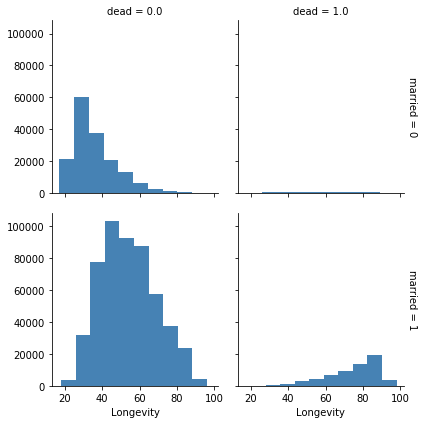

In [24]:
#look at data for married
g = sns.FacetGrid(data4, row='married', col='dead',margin_titles=True)
g.map(plt.hist, 'Longevity', color='steelblue', lw=0)
plt.show()

In [25]:
#calculate the Hazard risk for each age
sf = sm.SurvfuncRight(data4['Longevity'], data4['dead'])
sf.summary().head()

,Surv prob,Surv prob SE,num at risk,num events
Time,,,,
18.0,0.999997,0.000002,751495,2.0
19.0,0.999981,0.000005,750717,12.0
20.0,0.999940,0.000009,749189,31.0
21.0,0.999878,0.000013,746692,46.0
22.0,0.999825,0.000015,743450,40.0


(0.85, 1)

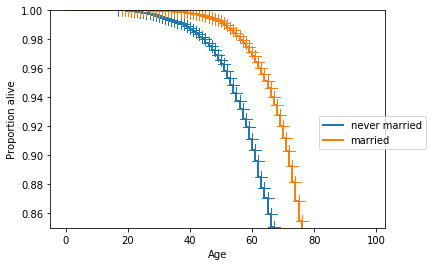

In [26]:
# survival plot for the married and unmarried
groups = data4.groupby('married')
ax = plt.axes()
marital_status = ['never married','married']
# Fitting a survival function for each group
for group in groups:
    sf = sm.SurvfuncRight(group[1]['Longevity'], group[1]['dead'])
    sf.plot(ax)
li = ax.get_lines()
plt.figlegend((li[0], li[2]), marital_status, 'center right')
ax.set_ylabel('Proportion alive')
ax.set_xlabel('Age')
ax.set_autoscaley_on(False)
ax.set_ylim([.85,1])


In [27]:
#cox_ph for marital status
mod = smf.phreg('Longevity ~  married', # The model
                data4, # The data
                status=data4['dead'].values # Whether values are right-censored
                ) 
rslt = mod.fit()
rslt.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                        Results: PHReg
==============================================================
Model:                   PH Reg        Sample size:     751495
Dependent variable:      Longevity     Num. events:     67184 
Ties:                    Breslow                              
--------------------------------------------------------------
         log HR log HR SE   HR      t     P>|t|  [0.025 0.975]
--------------------------------------------------------------
married -0.6716    0.0140 0.5109 -47.9976 0.0000 0.4971 0.5251
==============================================================
Confidence intervals are for the hazard ratios
"""

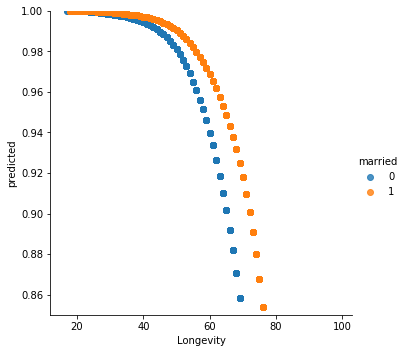

In [28]:
#plot predicted survival rates from model (married)
data5=data4[(data4['Longevity'].notnull()) & (data4['married'].notnull()) & (data4['dead'].notnull())]
data5['predicted'] = rslt.predict(pred_type='surv').predicted_values



sns.lmplot(x='Longevity', y='predicted', hue='married', data=data5,fit_reg=False,lowess=True)
plt.ylim(.85, 1)
plt.show()

In [29]:
data5.head()

,Unnamed: 0,YEAR,NHISPID,AGE,SEX,SEXORIEN,MARSTAT,BIRTHYR,MORTSTAT,MORTDODY,Longevity,dead,female,married,predicted
829402,3928174,1997,19970003080101,33,2,NaN,11,1963.0,2.0,9999.0,46.0,0.0,1,1,0.994110
829403,3928175,1997,19970003080102,36,1,NaN,11,1960.0,2.0,9999.0,49.0,0.0,0,1,0.991479
829404,3928178,1997,19970003090101,42,1,NaN,11,1954.0,1.0,1999.0,45.0,1.0,0,1,0.994769
829405,3928179,1997,19970003090102,52,2,NaN,11,1944.0,2.0,9999.0,65.0,0.0,1,1,0.948548
829407,3928182,1997,19970003100101,41,1,NaN,11,1955.0,2.0,9999.0,54.0,0.0,0,1,0.984121


In [ ]:
#cox_ph for marital status & female
mod = smf.phreg('Longevity ~  married', # The model
                data4, # The data
                status=data4['dead'].values # Whether values are right-censored
                ) 
rslt = mod.fit()
rslt.summary()

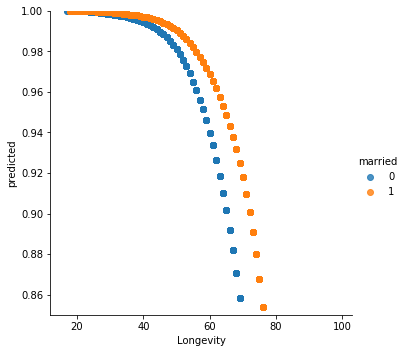

In [30]:
#plot predicted survival rates from model (married & female)
data6=data4[(data4['Longevity'].notnull()) & (data4['married'].notnull()) & (data4['female'].notnull()) & (data4['dead'].notnull())]
data5['predicted'] = rslt.predict(pred_type='surv').predicted_values



sns.lmplot(x='Longevity', y='predicted', hue='married', data=data5,fit_reg=False,lowess=True)
plt.ylim(.85, 1)
plt.show()